# Q Track Robot

This project tries to find pattern in large samples driven by randomness and probabilities. For this purpose, I have chosen Tracking a random walking robot in a grid.

## Importing all the required Libs for this project

In [1]:
import random as rn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

## Tracking the Robot

We first write the code for one iteration of the robot tryign to make his way out of a grid, starting anywhere in it

In [2]:
def rand_walk(s_x, s_y, b_x, b_y):
    moves = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    x, y, count = [s_x], [s_y], 0
    while -b_x <= x[-1] <= b_x and -b_y <= y[-1] <= b_y:
        dx, dy = rn.choice(moves)
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
        count += 1
    return x, y, count

This returns
1. Arrays of x and y co-ordinates it travelled to reach the boundary (i.e its path)
2. The number of steps it took to do so

We can optionally plot this path too, for one iteration that is,
We consider our base case to be a robot in a 10x10 grid, starting at the centre

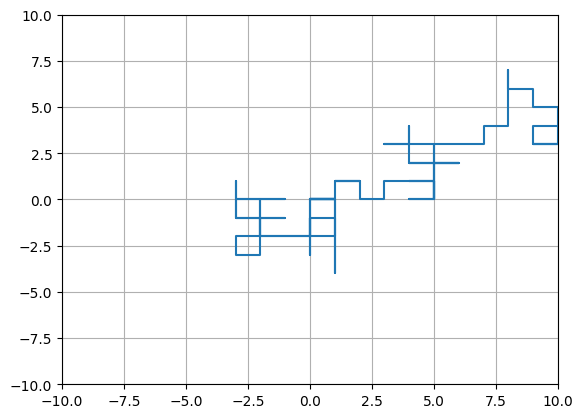

In [3]:
x_path, y_path, steps = rand_walk(0,0,10,10)
plt.plot(x_path, y_path)
plt.axis([-10,10,-10,10])
plt.grid(True)
plt.show()

What we are really interested in is not the individual path of a single iteration, but rather, its behaviour over multiple such iterations, and patterns that we might find in those

# Simulator

In [4]:
def simulator(s_x, s_y, b_x, b_y, walks):
    results = []
    for _ in range(walks):
        x,y, count = rand_walk(s_x, s_y, b_x, b_y)
        results.append({'final_x': x[-1], 'final_y': y[-1], 'steps': count})
    df = pd.DataFrame(results)
    return df

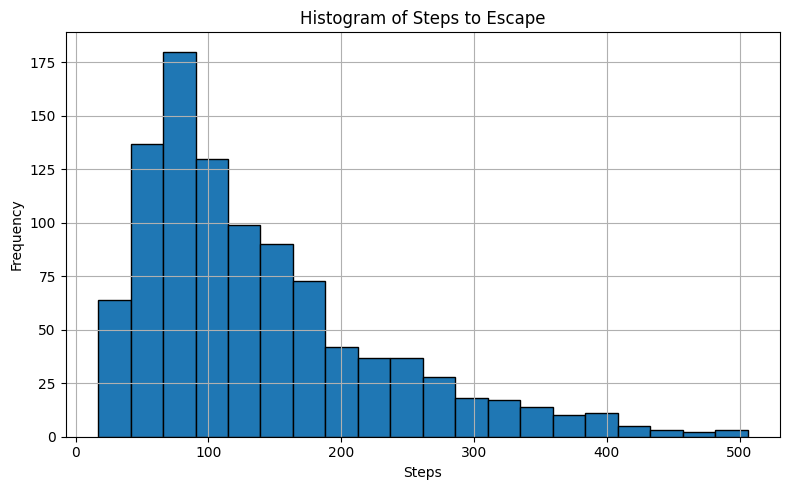

In [5]:
# simulating 1000 walks
results = simulator(0,0,10,10,1000)

plt.figure(figsize=(8, 5))
plt.hist(results['steps'], bins=20, edgecolor='black')
plt.title('Histogram of Steps to Escape')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The Histogram above tells us that the robot usually takes a certain number of steps before reaching the boundary, which was only evident by running multiple iterations of this 'random walker'

Varying the grid size varies the location of the peak in the histogram as shown below, my guess at this point is that the peak is at x^2 where x is grid size (or rather, at the area of the smallest rectangle formed by the starting position and any of the vertices of the grid)

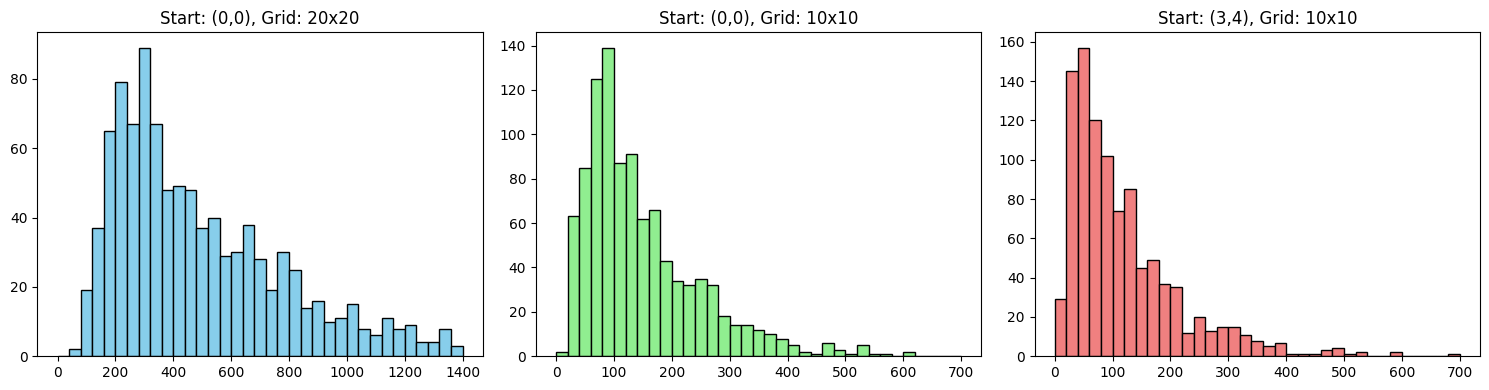

In [6]:
results1, results2, results3 = simulator(0,0,20,20,1000), simulator(0,0,10,10,1000), simulator(3,4,10,10,1000)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(results1['steps'], bins=35, range=(0,1400),color='skyblue', edgecolor='black')
plt.title("Start: (0,0), Grid: 20x20")

plt.subplot(1, 3, 2)
plt.hist(results2['steps'], bins=35,range=(0,700), color='lightgreen', edgecolor='black')
plt.title("Start: (0,0), Grid: 10x10")

plt.subplot(1, 3, 3)
plt.hist(results3['steps'], bins=35,range=(0,700), color='lightcoral', edgecolor='black')
plt.title("Start: (3,4), Grid: 10x10")

plt.tight_layout()
plt.show()

# Heatmaps

Another very interesting thing we can plot, is a heatmap of the final positions of the robot

In [7]:
def plot_heatmap(df,b_x,b_y):
    x_vals, y_vals = df['final_x'], df['final_y']
    bin_range = (-b_x - 2, b_x + 2)
    bins = np.arange(bin_range[0], bin_range[1] + 1)

    heatmap, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=[bins, bins])
    fig, ax = plt.subplots(figsize=(8, 6))
    masked = np.ma.masked_where(heatmap == 0, heatmap)

    cax = ax.imshow(masked.T, origin='lower', cmap='plasma',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(cax, label='Escape Frequency')
    ax.set_title('Escape Points Heatmap')
    ax.set_xlabel('Final X')
    ax.set_ylabel('Final Y')
    plt.tight_layout()
    plt.show()
    plt.close()

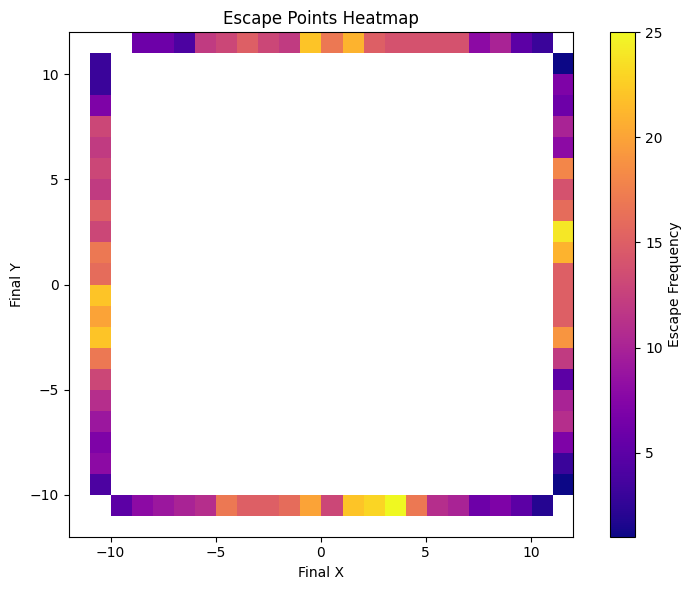

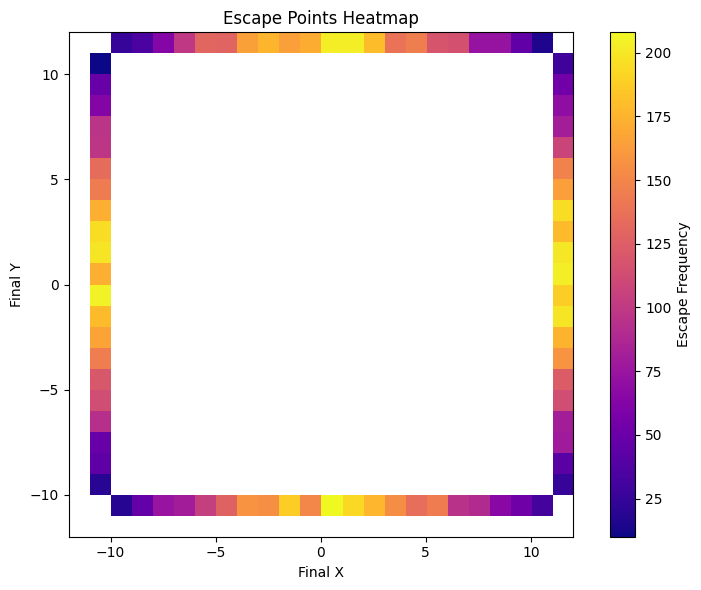

In [8]:
results1, results2= simulator(0,0,10,10,1000), simulator(0,0,10,10,10000)
plot_heatmap(results1, 10,10)
plot_heatmap(results2,10,10)

We see that the more iterations it goes through, it becomes clearer that it usually escapes through the nearest edge, since in these iterations, it starts at 0,0 with a grid from -10 to 10 in both axis, it is equally probable for it to escape through the centres of any of the four edges

But what if we place it off centre

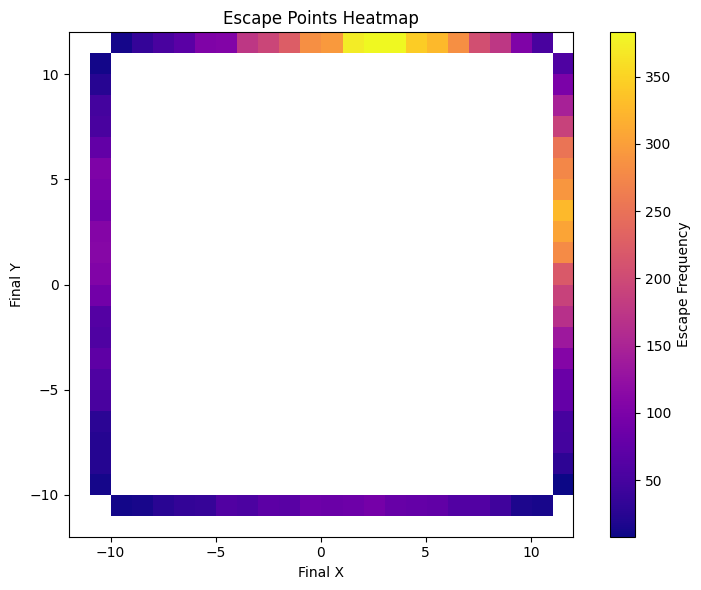

In [9]:
results3 = simulator(3,4,10,10,10000)
plot_heatmap(results3, 10,10)

In hindsight it seems very obvious that the robot should in most cases escape through the shortest route, but if you give it thought, is it really obvious?
Its not forbidden to backtrack, therefore it can wander anywhere on the map before making an exit, so how is it most likely to exit via the nearest exit?

To answer the above,
Every step is random — but the accumulated probability of reaching a nearby edge in fewer steps is higher. Each step adds a chance of escape — and if one edge is only 5 steps away while the other is 15, the walker gets many more opportunities to stumble out early in that direction.

hence it starts to make sense again

Now let us gather, plot and analyze how the number of steps varies as we change the size of the grid. We did have an intuition that it would be somehow related to x^2 the grid size, so lets check if it is indeed the case.

# Analysis

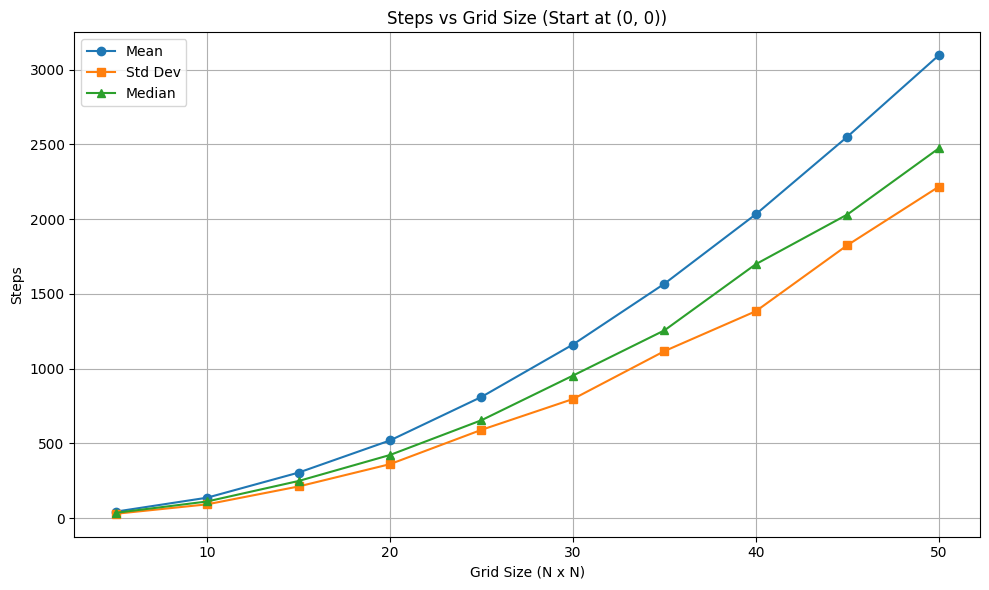

In [10]:
def plot_step_data():

    df = pd.read_csv("all_results.csv")
    df['grid_n'] = df['grid_x']
    df = df.sort_values(by='grid_n')
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['grid_n'], df['mean_steps'], label='Mean', marker='o')
    plt.plot(df['grid_n'], df['std_steps'], label='Std Dev', marker='s')
    plt.plot(df['grid_n'], df['median_steps'], label='Median', marker='^')

    plt.title("Steps vs Grid Size (Start at (0, 0))")
    plt.xlabel("Grid Size (N x N)")
    plt.ylabel("Steps")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_step_data()

The function above is drawing from a csv file that has data about different grid sizes, also some averages and medians

Now let us see if we can try and match it to some curve of the quadratic form

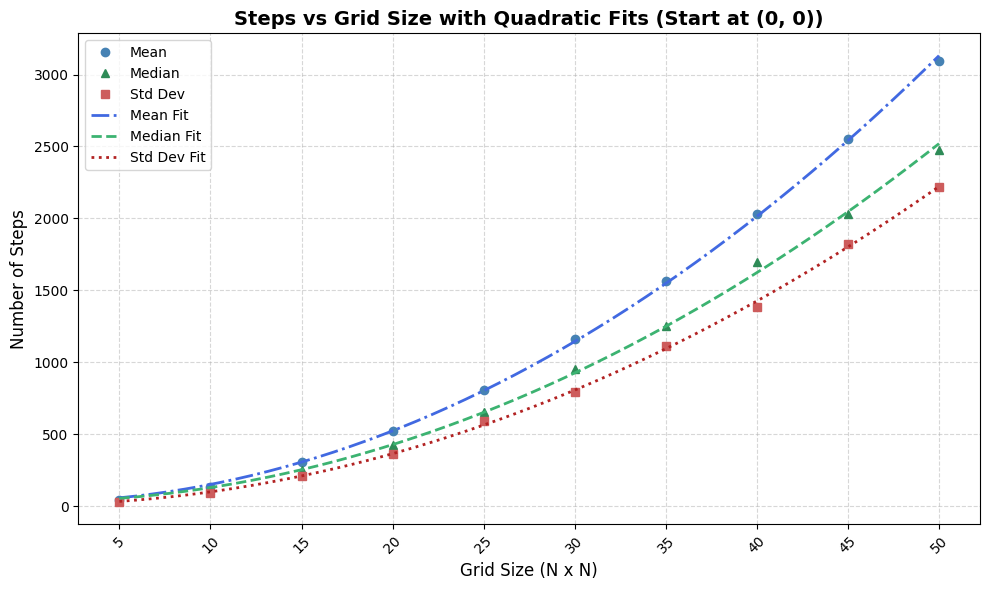

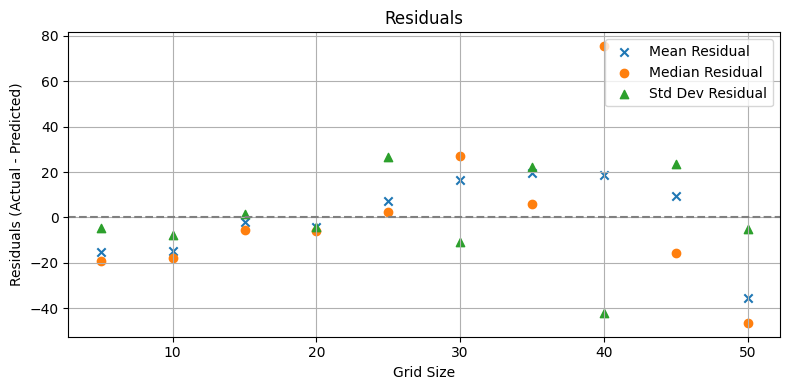

R² for Mean Fit: 0.9997
R² for Median Fit: 0.9985
R² for Std Dev Fit: 0.9993


In [11]:
def fit_and_analysis():

    df = pd.read_csv("all_results.csv")
    df['grid_n'] = df['grid_x']
    df = df.sort_values(by='grid_n')

    def quad_model(x, a, b):
        return a * x**2 + b

    x_data = df['grid_n']
    x_fit = np.linspace(min(x_data), max(x_data), 200)

    plt.figure(figsize=(10, 6))

    # Plot data
    plt.plot(x_data, df['mean_steps'], 'o', label='Mean', color='steelblue')
    plt.plot(x_data, df['median_steps'], '^', label='Median', color='seagreen')
    plt.plot(x_data, df['std_steps'], 's', label='Std Dev', color='indianred')

    # Fit
    mean_params, _ = curve_fit(quad_model, x_data, df['mean_steps'])
    y_fit_mean = quad_model(x_fit, *mean_params)
    plt.plot(x_fit, y_fit_mean, '-.', label='Mean Fit', color='royalblue', linewidth=2)
    
    median_params, _ = curve_fit(quad_model, x_data, df['median_steps'])
    y_fit_median = quad_model(x_fit, *median_params)
    plt.plot(x_fit, y_fit_median, '--', label='Median Fit', color='mediumseagreen', linewidth=2)

    std_params, _ = curve_fit(quad_model, x_data, df['std_steps'])
    y_fit_std = quad_model(x_fit, *std_params)
    plt.plot(x_fit, y_fit_std, ':', label='Std Dev Fit', color='firebrick', linewidth=2)

    plt.title("Steps vs Grid Size with Quadratic Fits (Start at (0, 0))", fontsize=14, weight='bold')
    plt.xlabel("Grid Size (N x N)", fontsize=12)
    plt.ylabel("Number of Steps", fontsize=12)
    plt.xticks(x_data, rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Residual Plot
    residual_mean = df['mean_steps'] - quad_model(x_data, *mean_params)
    residual_median = df['median_steps'] - quad_model(x_data, *median_params)
    residual_std = df['std_steps'] - quad_model(x_data, *std_params)
    
    plt.figure(figsize=(8,4))
    plt.scatter(df['grid_n'], residual_mean, marker='x', label='Mean Residual')
    plt.scatter(df['grid_n'], residual_median, marker='o', label='Median Residual')
    plt.scatter(df['grid_n'], residual_std, marker='^', label='Std Dev Residual')
       
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Residuals")
    plt.xlabel("Grid Size")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # R² values
    r2_mean = r2_score(df['mean_steps'], quad_model(x_data, *mean_params))
    print(f"R² for Mean Fit: {r2_mean:.4f}")
    
    r2_median = r2_score(df['median_steps'], quad_model(x_data, *median_params))
    print(f"R² for Median Fit: {r2_median:.4f}")
    
    r2_std = r2_score(df['std_steps'], quad_model(x_data, *std_params))
    print(f"R² for Std Dev Fit: {r2_std:.4f}")

fit_and_analysis()

In the first plot we see that our 'guess' was correct and a quadratic plot does indeed fit the points, just to make sure, we also plot the residuals, and see no obvious patters that emerge, that may be causing any systematic errors

Calculating the R^2 values, it furthers solidifies the conclusion that these graphs do perfectly fit

# Summary

This project was an amazing experience, especially in working with probabilities and randomness. The visualization aspect made it all the more engaging.

I learned how effective Matplotlib can be for representing data and gained valuable exposure to libraries that support data analysis.

It was surprising to see how closely the probability graphs aligned with theoretical expectations.

Overall, the project has been rewarding, and I look forward to engaging in more such projects.
